## Change variables in this cell 
    - specify the day you want to analyze.
    - specifiy whether correct, incorrect or all trials will be analyzed.

In [1]:
outcome2ana = 'corr' # '', corr', 'incorr' : analyze all, correct or incorrect trials

mousename = 'fni17'
imagingFolder = '151102'
mdfFileNumber = [1,2] 


### Import Libraries and Modules

In [2]:
import scipy.io as scio
import scipy as sci
import numpy as np
import numpy.random as rng

from crossValidateModel import crossValidateModel
from linearSVM import linearSVM
from compiler.ast import flatten
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)
from IPython.display import display
import sklearn.svm as svm
import os

/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: The compiler package is deprecated and removed in Python 3.x.


In [3]:
import sys
print sys.path
sys.path.append('/home/farznaj/Documents/trial_history/imaging')
# print sys.path

['', '/home/farznaj/anaconda2/lib/python27.zip', '/home/farznaj/anaconda2/lib/python2.7', '/home/farznaj/anaconda2/lib/python2.7/plat-linux2', '/home/farznaj/anaconda2/lib/python2.7/lib-tk', '/home/farznaj/anaconda2/lib/python2.7/lib-old', '/home/farznaj/anaconda2/lib/python2.7/lib-dynload', '/home/farznaj/anaconda2/lib/python2.7/site-packages', '/home/farznaj/anaconda2/lib/python2.7/site-packages/Sphinx-1.4.1-py2.7.egg', '/home/farznaj/anaconda2/lib/python2.7/site-packages/setuptools-23.0.0-py2.7.egg', '/home/farznaj/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/home/farznaj/.ipython']


In [4]:
# Set mat file names

pnev2load = [] # which pnev file to load: indicates index of date-sorted files: use 0 for latest. Set [] to load the latest one.
signalCh = [2] # since gcamp is channel 2, should be always 2.

from setImagingAnalysisNamesP import *

imfilename, pnevFileName = setImagingAnalysisNamesP(mousename, imagingFolder, mdfFileNumber, signalCh=signalCh, pnev2load=pnev2load)

postName = os.path.join(os.path.dirname(pnevFileName), 'post_'+os.path.basename(pnevFileName))

print(imfilename)
print(pnevFileName)
print(postName)


/home/farznaj/Shares/Churchland/data/fni17/imaging/151102/151102_001-002.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151102/151102_001-002_ch2-PnevPanResults-160830-200511.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151102/post_151102_001-002_ch2-PnevPanResults-160830-200511.mat


### Load matlab variables

In [5]:
# Load aligned traces, frames, frame of event of interest, and epoch over which we will average the responses to do SVM analysis
Data = scio.loadmat(postName, variable_names=['stimAl'],squeeze_me=True,struct_as_record=False)

eventI = Data['stimAl'].eventI - 1 # remember difference indexing in matlab and python!
traces_al_sm = Data['stimAl'].traces.astype('float') # traces_al_sm
time_aligned = Data['stimAl'].time.astype('float')
ep = Data['stimAl'].ep - 1 # remember difference indexing in matlab and python!
# print(eventI)
print(np.shape(traces_al_sm))
# print(np.shape(time_aligned))
# print(ep)

Data = scio.loadmat(postName, variable_names=['firstSideTryAl'],squeeze_me=True,struct_as_record=False)
traces_al_ch = Data['firstSideTryAl'].traces.astype('float')
time_choiceAligned = Data['firstSideTryAl'].time.astype('float')
print(np.shape(traces_al_ch))
# print(np.shape(time_choiceAligned))


# Load outcomes and allResp_HR_LR
Data = scio.loadmat(postName, variable_names=['outcomes', 'allResp_HR_LR'])

outcomes = (Data.pop('outcomes').astype('float'))[0,:]
allResp_HR_LR = (Data.pop('allResp_HR_LR').astype('float'))[0,:]
# print(outcomes.shape)
# print(allResp_HR_LR.shape)


# Set to nan those trials in outcomes and allRes that are nan in traces_al_sm
I = (np.argwhere((~np.isnan(traces_al_sm).sum(axis=0)).sum(axis=1)))[0][0] # first non-nan neuron
allTrs2rmv = np.argwhere(sum(np.isnan(traces_al_sm[:,I,:])))
print(np.shape(allTrs2rmv))

outcomes[allTrs2rmv] = np.nan
allResp_HR_LR[allTrs2rmv] = np.nan


(76, 297, 178)
(78, 297, 178)
(178,)
(178,)
(20, 1)


### Set traces (frames x neurons x trials), X (trials x neurons) and Y (trials x 1)
    traces are aligned on stimulus and choice
    X matrix (size trials x neurons) that contains neural responses at different trials.
    Y choice of high rate (modeled as 1) and low rate (modeled as 0)

In [6]:
# Set Y: the response vector

# if trialHistAnalysis
#     popClassifier_trialHistory
# else
choiceVec0 = np.transpose(allResp_HR_LR);  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.

if outcome2ana == 'corr':
    choiceVec0[outcomes!=1] = np.nan; # analyze only correct trials.
elif outcome2ana == 'incorr':
    choiceVec0[outcomes!=0] = np.nan; # analyze only incorrect trials.

# Y = choiceVec0
print(choiceVec0.shape)


(178,)


In [7]:
# Set X: the predictor matrix (trials x neurons) that shows average of spikes for a particular epoch for each trial and neuron.

spikeAveEp0 = np.transpose(np.nanmean(traces_al_sm[ep,:,:], axis=0)) # trials x neurons
# spikeAveEp0 = np.matrix(np.transpose(np.nanmean(traces_al_sm[ep,:,:], axis=0))) # trials x neurons

# X = spikeAveEp0;
print(spikeAveEp0.shape)


(178, 297)


/home/farznaj/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [8]:
# Identify neurons that did not fire in any of the trials and later exclude them

nTrsWithSpike = np.sum(spikeAveEp0 > 0, axis=0) # shows for each neuron, in how many trials the activity was above 0.
NsExcluded = (nTrsWithSpike < 1) # identify neurons that were active in no trials.

sum(NsExcluded)

/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


2

In [10]:
# Set final traces by excluding nan trials and non-active neurons

'''
#dirName = 'SVM_151102_001-002_ch2-PnevPanResults-160624-113108';
dirName = 'SVM_151029_003_ch2-PnevPanResults-160426-191859';
#dirName = '/home/farznaj/Shares/Churchland/data/fni17/imaging/151022/XY_fni17_151022 XY_lassoSVM.mat';
Data = scio.loadmat(dirName, variable_names=['X', 'Y', 'time_aligned', 'non_filtered', 'traces_al_1stSideTry', 'time_aligned_1stSideTry']);
X = Data.pop('X').astype('float')
Y = np.squeeze(Data.pop('Y')).astype('int')
time_aligned = np.squeeze(Data.pop('time_aligned')).astype('float')
Xt = Data.pop('non_filtered').astype('float')
Xt_choiceAligned = Data.pop('traces_al_1stSideTry').astype('float')
time_choiceAligned = np.squeeze(Data.pop('time_aligned_1stSideTry')).astype('float')
'''

# Exclude nan trials
mskNan = (np.sum(np.isnan(spikeAveEp0), axis = 1) + np.isnan(choiceVec0)) != 0 # NaN trials
# sum(mskNan)
X = spikeAveEp0[~mskNan,:];
Y = choiceVec0[~mskNan];

Xt = traces_al_sm[:, :, ~mskNan];
Xt_choiceAligned = traces_al_ch[:, :, ~mskNan];
# Xt = traces_al_sm[:, :, np.sum(np.sum(np.isnan(traces_al_sm), axis =0), axis =0)==0];
# Xt_choiceAligned = traces_al_ch[:, :, np.sum(np.sum(np.isnan(traces_al_ch), axis =0), axis =0)==0];


# Exclude non-active neurons (ie neurons that don't fire in any of the trials during ep)
X = X[:,~NsExcluded]
Xt = Xt[:,~NsExcluded,:]
Xt_choiceAligned = Xt_choiceAligned[:,~NsExcluded,:]


numTrials, numNeurons = X.shape

print ' The data has %d trials recorded from %d neurons' %(numTrials, numNeurons)
print ' The data has %d frames recorded from %d neurons at %d trials' %Xt.shape

print(X.shape)
print(Y.shape)
print(Xt.shape)
print(Xt_choiceAligned.shape)

 The data has 119 trials recorded from 295 neurons
 The data has 76 frames recorded from 295 neurons at 119 trials
(119, 295)
(119,)
(76, 295, 119)
(78, 295, 119)


## Features normalization and scaling
    To removed effects related to scaling and bias of each neuron, we need to zscore data (i.e., make data mean 0 and variance 1 for each neuron) 

In [11]:
meanX = np.mean(X, axis = 0);
stdX = np.std(X, axis = 0);
X = (X-meanX)/stdX;
Tc, Nc, Cc = Xt_choiceAligned.shape
Xtc_N = np.reshape(Xt_choiceAligned.transpose(0 ,2 ,1), (Tc*Cc, Nc), order = 'F')
Xtc_N = (Xtc_N-meanX)/stdX
Xtc = np.reshape(Xtc_N, (Tc, Cc, Nc), order = 'F').transpose(0 ,2 ,1)


T, N, C = Xt.shape
Xt_N = np.reshape(Xt.transpose(0 ,2 ,1), (T*C, N), order = 'F')
Xt_N = (Xt_N-meanX)/stdX
Xt = np.reshape(Xt_N, (T, C, N), order = 'F').transpose(0 ,2 ,1)

## Divide data into high- and low-rate trials

In [12]:
Y_HR = Y[Y==1];
X_HR = X[Y==1,:];
Y_LR = Y[Y==0];
X_LR = X[Y==0,:];
print ' %d trials are high rate and %d trials are low rate' %(len(Y_HR), len(Y_LR))

 58 trials are high rate and 61 trials are low rate


## Handle imbalance in the number of trials
    - Still need to think about that.

## Identify the best regularization parameter:
    Perform 10-fold cross validation to obtain the best regularization parameter

In [13]:
regType = 'l1'
kfold = 10;
numSamples = 100;
if regType == 'l1':
    print 'running l1 svm classification\r' 
    cvect = 10**(np.arange(-4, 6,0.2))/numTrials;
elif regType == 'l2':
    print 'running l2 svm classification\r' 
    cvect = 10**(np.arange(-4, 6,0.2));

print 'try the following regularization values: %\n', cvect

perClassErrorTrain = np.ones((numSamples, len(cvect)))+np.nan;
perClassErrorTest = np.ones((numSamples, len(cvect)))+np.nan;
for s in range(numSamples):
    for i in range(len(cvect)):
        if regType == 'l1':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cvect[i])
        elif regType == 'l2':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cvect[i])

        perClassErrorTrain[s, i] = summary.perClassErrorTrain;
        perClassErrorTest[s, i] = summary.perClassErrorTest;

meanPerClassErrorTrain = np.mean(perClassErrorTrain, axis = 0);
semPerClassErrorTrain = np.std(perClassErrorTrain, axis = 0)/np.sqrt(numSamples);

meanPerClassErrorTest = np.mean(perClassErrorTest, axis = 0);
semPerClassErrorTest = np.std(perClassErrorTest, axis = 0)/np.sqrt(numSamples);
ix = np.argmin(meanPerClassErrorTest);
cbest = cvect[meanPerClassErrorTest <= (meanPerClassErrorTest[ix]+semPerClassErrorTest[ix])];
cbest = cbest[0]; # best regularization term based on minError+SE criteria

running l1 svm classification
try the following regularization values: %
[  8.40336134e-07   1.33184302e-06   2.11082893e-06   3.34543841e-06
   5.30216256e-06   8.40336134e-06   1.33184302e-05   2.11082893e-05
   3.34543841e-05   5.30216256e-05   8.40336134e-05   1.33184302e-04
   2.11082893e-04   3.34543841e-04   5.30216256e-04   8.40336134e-04
   1.33184302e-03   2.11082893e-03   3.34543841e-03   5.30216256e-03
   8.40336134e-03   1.33184302e-02   2.11082893e-02   3.34543841e-02
   5.30216256e-02   8.40336134e-02   1.33184302e-01   2.11082893e-01
   3.34543841e-01   5.30216256e-01   8.40336134e-01   1.33184302e+00
   2.11082893e+00   3.34543841e+00   5.30216256e+00   8.40336134e+00
   1.33184302e+01   2.11082893e+01   3.34543841e+01   5.30216256e+01
   8.40336134e+01   1.33184302e+02   2.11082893e+02   3.34543841e+02
   5.30216256e+02   8.40336134e+02   1.33184302e+03   2.11082893e+03
   3.34543841e+03   5.30216256e+03]


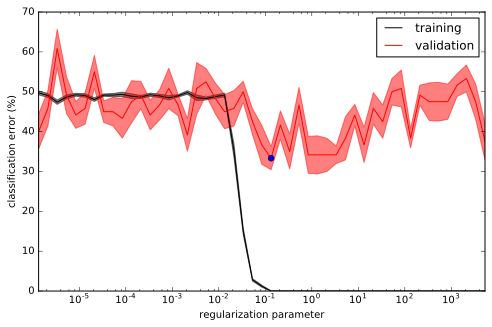

In [14]:
##%%%%%% plot coss-validation results
plt.figure('cross validation')

plt.fill_between(cvect, meanPerClassErrorTrain-semPerClassErrorTrain, meanPerClassErrorTrain+ semPerClassErrorTrain, alpha=0.5, edgecolor='k', facecolor='k')
plt.fill_between(cvect, meanPerClassErrorTest-semPerClassErrorTest, meanPerClassErrorTest+ semPerClassErrorTest, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(cvect, meanPerClassErrorTrain, 'k', label = 'training')
plt.plot(cvect, meanPerClassErrorTest, 'r', label = 'validation')
plt.plot(cvect[cvect==cbest], meanPerClassErrorTest[cvect==cbest], 'bo')
plt.xlim([cvect[1], cvect[-1]])
plt.xscale('log')
plt.xlabel('regularization parameter')
plt.ylabel('classification error (%)')
plt.legend()

## Train the best SVM model

0.0


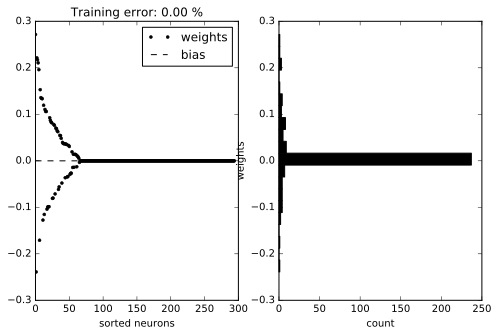

In [15]:
if regType == 'l1':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
elif regType == 'l2':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l2', dual=True)

linear_svm.fit(X, Y)
    
w = np.squeeze(linear_svm.coef_);
b = linear_svm.intercept_;

plt.figure()
plt.subplot(1,2,1)
plt.plot(w[np.argsort(abs(w))[::-1]], 'k.', label = 'weights')
plt.plot(np.ones(len(w))*b, 'k--', label = 'bias')
plt.xlabel('sorted neurons')
plt.legend()
plt.title(('Training error: %.2f %%' %(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)))
print abs(((np.dot(X,w)+b)>0).astype('float')-Y.astype('float')).sum()/len(Y)*100 # this is the prediction formula
plt.subplot(1,2,2)
plt.hist(w, 20,orientation='horizontal', color = 'k')
plt.ylabel('weights')
plt.xlabel('count')


## Null distribution using shuffles


In [16]:
numShuffles = 100
summary_data = [];
summary_shfl = [];
perClassErrorTrain_data = [];
perClassErrorTest_data = []
perClassErrorTrain_shfl = [];
perClassErrorTest_shfl = [];
w_data = []
b_data = []
w_shfl = []
b_shfl = []
permIxsList = [];
for i in range(numShuffles):
    permIxs = rng.permutation(numTrials);
    permIxsList.append(permIxs);
    if regType == 'l1':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))
    elif regType == 'l2':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))
        
    perClassErrorTrain_data.append(summary_data[i].perClassErrorTrain);
    perClassErrorTest_data.append(summary_data[i].perClassErrorTest);
    w_data.append(np.squeeze(summary_data[i].model.coef_));
    b_data.append(summary_data[i].model.intercept_);
        
    perClassErrorTrain_shfl.append(summary_shfl[i].perClassErrorTrain);
    perClassErrorTest_shfl.append(summary_shfl[i].perClassErrorTest);
    w_shfl.append(np.squeeze(summary_shfl[i].model.coef_));
    b_shfl.append(summary_shfl[i].model.intercept_);



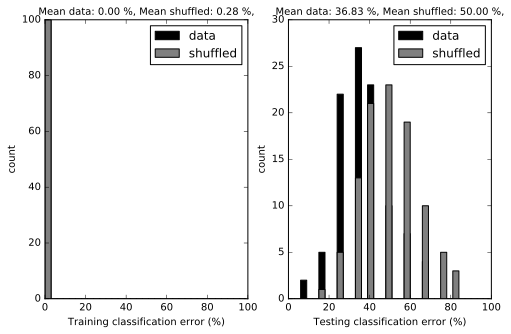

In [17]:
binEvery = 3; # bin width
plt.figure()
plt.subplot(1,2,1)
plt.hist(perClassErrorTrain_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTrain_shfl, np.arange(0,100,binEvery), color = [0.5, 0.5, 0.5], label = 'shuffled');
plt.xlabel('Training classification error (%)')
plt.ylabel('count')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%,' %(np.mean(perClassErrorTrain_data), np.mean(perClassErrorTrain_shfl)), fontsize = 10)
plt.legend()

plt.subplot(1,2,2)
plt.hist(perClassErrorTest_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTest_shfl, np.arange(0,100,binEvery), color = [0.5, 0.5, 0.5], label = 'shuffled');
plt.legend()
plt.xlabel('Testing classification error (%)')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%,' %(np.mean(perClassErrorTest_data), np.mean(perClassErrorTest_shfl)), fontsize = 10)
plt.ylabel('count')

## Data projections

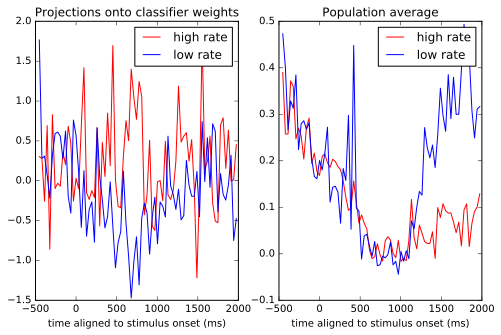

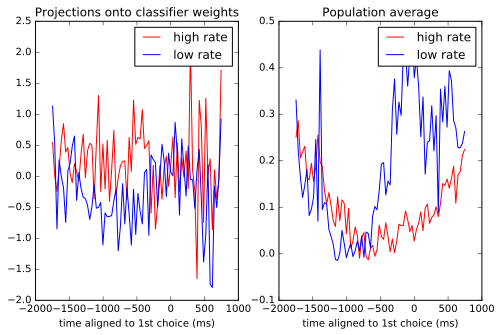

In [18]:
w_normalized = w/sci.linalg.norm(w);
XtcN_w = np.dot(Xtc_N, w_normalized);
Xtc_w = np.reshape(XtcN_w, (Tc,Cc), order='F');

XtN_w = np.dot(Xt_N, w_normalized);
Xt_w = np.reshape(XtN_w, (T,C), order='F');

plt.figure()
plt.subplot(1,2,1)
plt.plot(time_aligned, np.mean(Xt_w[:, Y>0],  axis = 1), 'r', label = 'high rate')
plt.plot(time_aligned, np.mean(Xt_w[:, Y<1],  axis = 1), 'b', label = 'low rate')
plt.xlabel('time aligned to stimulus onset (ms)')
plt.title('Projections onto classifier weights')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time_aligned, np.mean(Xt[:, :, Y<1],  axis = (1, 2)), 'r', label = 'high rate')
plt.plot(time_aligned, np.mean(Xt[:, :, Y>0],  axis = (1, 2)), 'b', label = 'low rate')
plt.xlabel('time aligned to stimulus onset (ms)')
plt.title('Population average')
plt.legend()

plt.figure()
plt.subplot(1,2,1)
plt.plot(time_choiceAligned, np.mean(Xtc_w[:, Y>0],  axis = 1), 'r', label = 'high rate')
plt.plot(time_choiceAligned, np.mean(Xtc_w[:, Y<1],  axis = 1), 'b', label = 'low rate')
plt.xlabel('time aligned to 1st choice (ms)')
plt.title('Projections onto classifier weights')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time_choiceAligned, np.mean(Xtc[:, :, Y<1],  axis = (1, 2)), 'r', label = 'high rate')
plt.plot(time_choiceAligned, np.mean(Xtc[:, :, Y>0],  axis = (1, 2)), 'b', label = 'low rate')
plt.xlabel('time aligned to 1st choice (ms)')
plt.title('Population average')
plt.legend()


## Classification error per time

In [19]:
perClassEr_t = [];
for t in range(T):
    perClassEr_t.append(abs(linear_svm.predict(np.squeeze(Xt[t, :, :]).T)-Y).mean()*100)

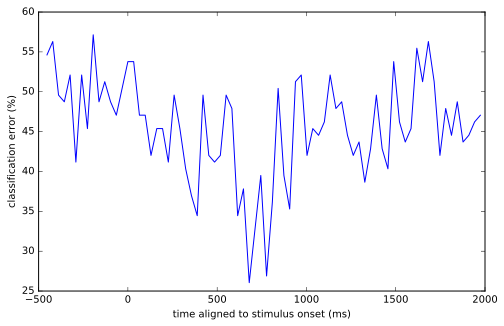

In [20]:
plt.figure()
plt.plot(time_aligned, perClassEr_t)
plt.xlabel('time aligned to stimulus onset (ms)')
plt.ylabel('classification error (%)')

## Save results


In [25]:
svmName = os.path.join(os.path.dirname(pnevFileName), 'svmResults_'+os.path.basename(pnevFileName))
print(svmName)

scio.savemat(svmName, {'X': X, 'Y': Y, 'Xt_N': Xt_N, 'Xt': Xt, 'w':w, 'b': b })

/home/farznaj/Shares/Churchland/data/fni17/imaging/151102/svmResults_151102_001-002_ch2-PnevPanResults-160830-200511.mat
